In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_hough(img):
    edges = cv2.Canny(img, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=30, minLineLength=50, maxLineGap=190)
    mask = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return mask

def get_contour(houghImg):
    contours, _ = cv2.findContours(houghImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_area = 0
    selected_contour_exact = None
    selected_contour_appx = None
    for contour in contours:
        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                selected_contour_exact = contour
                selected_contour_appx = approx
    return selected_contour_exact, selected_contour_appx

def shift_perspective(img, contour, target_vertices):
    original_vertices = contour.reshape(-1, 2).astype(np.float32)
    perspective_transform_matrix = cv2.getPerspectiveTransform(original_vertices, target_vertices)
    max_x = int(max(target_vertices[:, 0]))
    max_y = int(max(target_vertices[:, 1]))
    return cv2.warpPerspective(img, perspective_transform_matrix, (max_x, max_y), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def tc14_preprocessing(original_img):
    _, thresh_img = cv2.threshold(original_img, 90, 255, cv2.THRESH_BINARY)
    hough_lines_14 = get_hough(thresh_img)
    exact, appx = get_contour(hough_lines_14)
    cont_img = original_img.copy()
    if appx is not None:
        cv2.drawContours(cont_img, [appx], -1, (0, 0, 0), 4)
    x, y, w, h = cv2.boundingRect(appx)
    target_vertices = np.array([[w-1, 0], [0, 0], [0, h-1], [w-1, h-1]], dtype=np.float32)
    warped_image = shift_perspective(original_img, appx, target_vertices)
    _, thresh_shifted_img = cv2.threshold(warped_image, 60, 255, cv2.THRESH_BINARY)

    return thresh_shifted_img

def calculate_vectors(vertices):
    vectors = []
    n = len(vertices)
    for i in range(n):
        vector = vertices[(i+1) % n] - vertices[i]
        vectors.append(vector)
    return vectors

def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle_radians = np.arccos(np.clip(dot_product, -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

def is_parallel_to_axes(vector):
    # Check if the vector is almost parallel to the x-axis or y-axis
    angle_with_x_axis = np.degrees(np.arctan2(vector[1], vector[0]))
    if abs(angle_with_x_axis) < 10 or abs(angle_with_x_axis) > 170:
        return True
    return False

def check_angles(vertices):
    vectors = calculate_vectors(vertices)
    n = len(vectors)
    rt = False
    for i in range(n):
        angle = angle_between(vectors[i], vectors[(i+1) % n])
        if 85 <= angle <= 95:
            if is_parallel_to_axes(vectors[i]) or is_parallel_to_axes(vectors[(i+1) % n]):
                rt = True
    return rt


def needs_preprocessing(original_img):
    _, thresh_img = cv2.threshold(original_img, 90, 255, cv2.THRESH_BINARY)
    hough_lines = get_hough(thresh_img)
    exact, appx = get_contour(hough_lines)
    if appx is not None:
        vertices = np.array([pt[0] for pt in appx])
        if not check_angles(vertices):
            return True
    return False

def process_image(img_path):
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if needs_preprocessing(original_img):
        image = tc14_preprocessing(original_img)
    else:
        image = original_img

    return image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


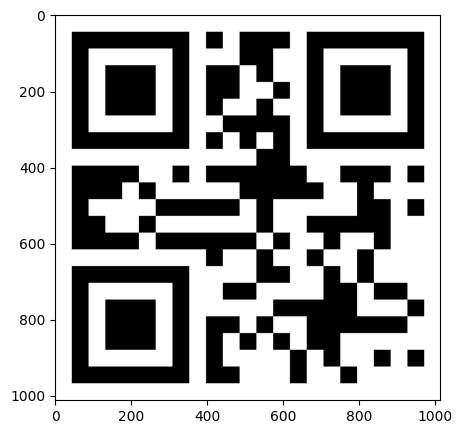

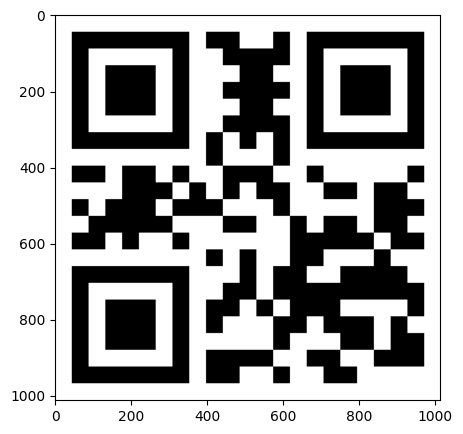

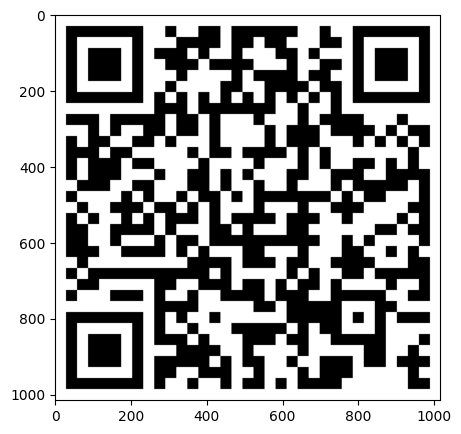

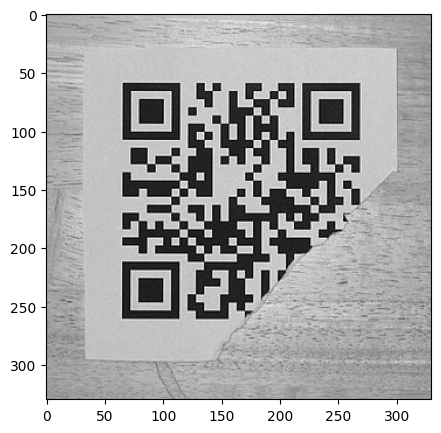

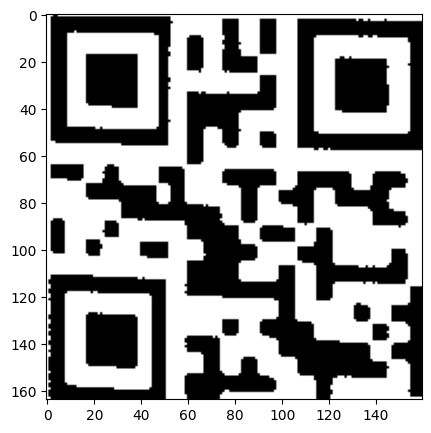

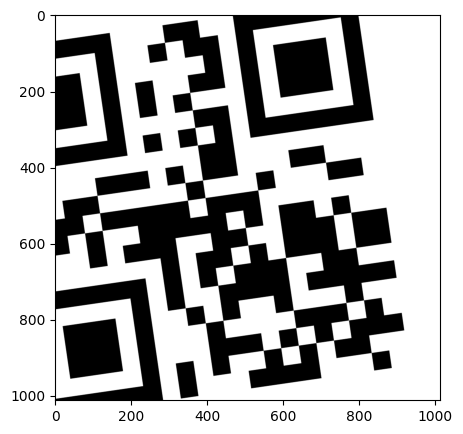

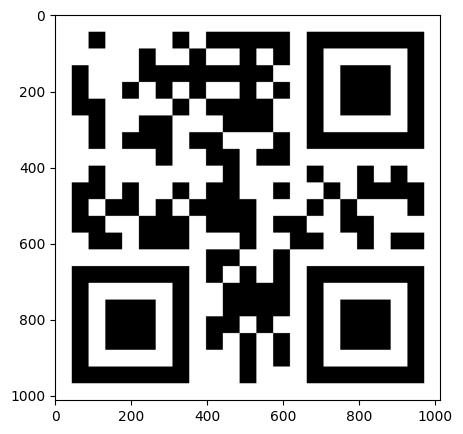

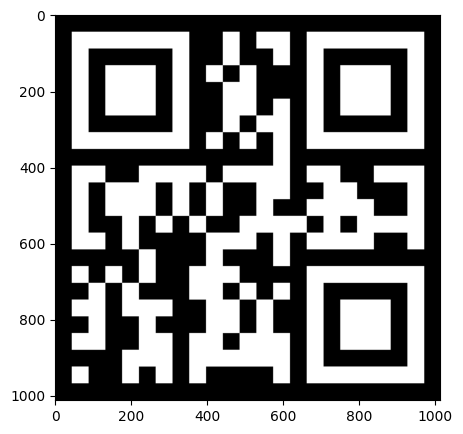

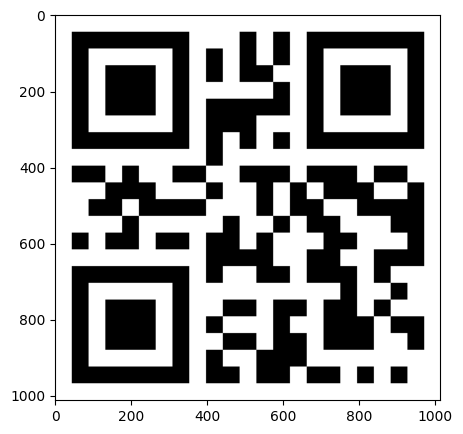

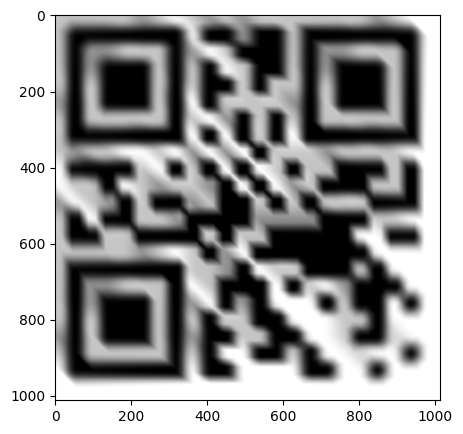

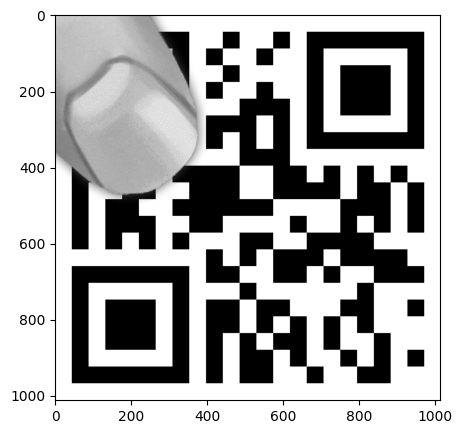

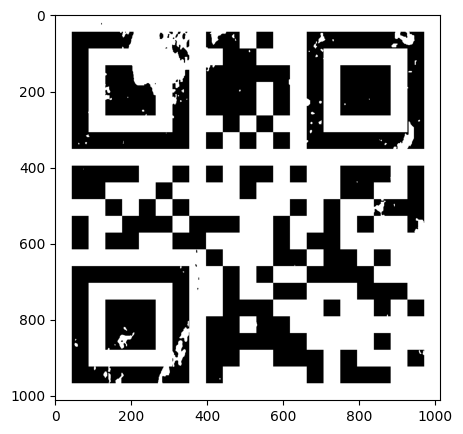

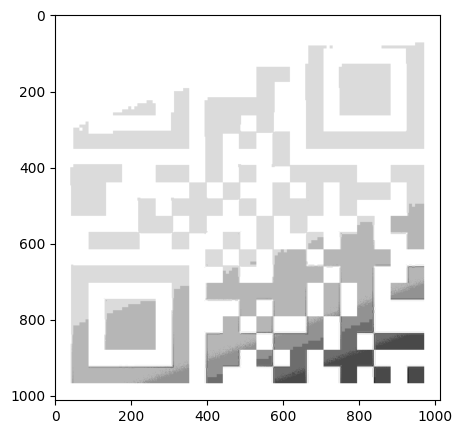

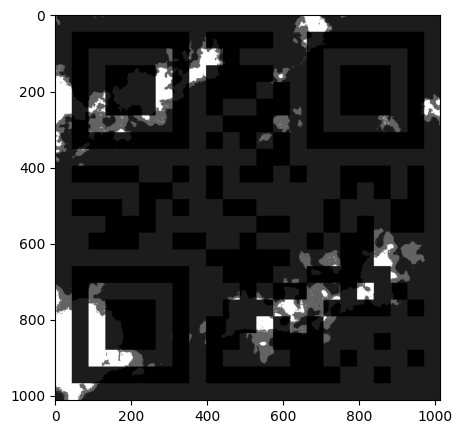

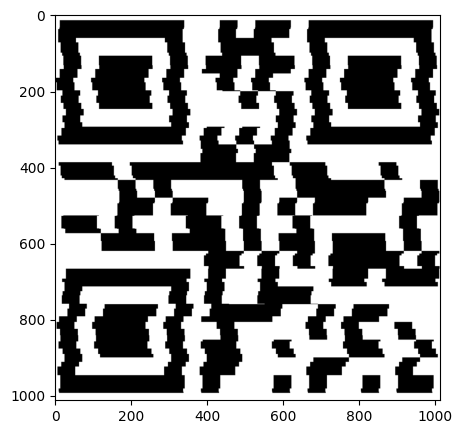

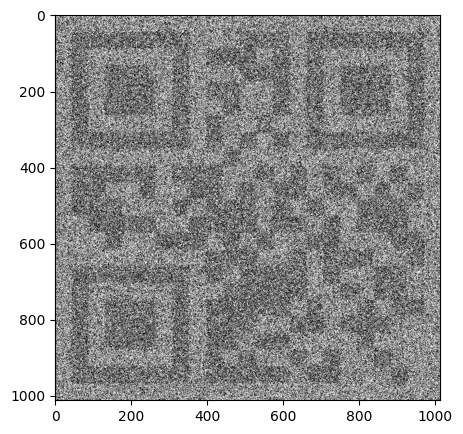

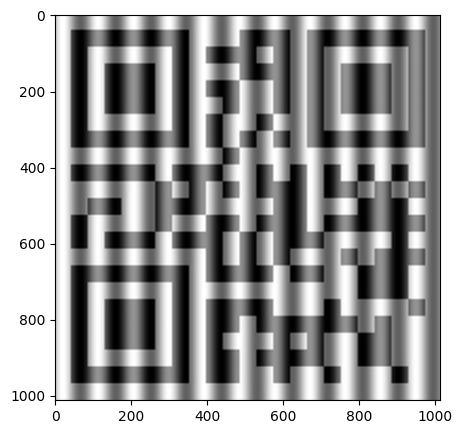

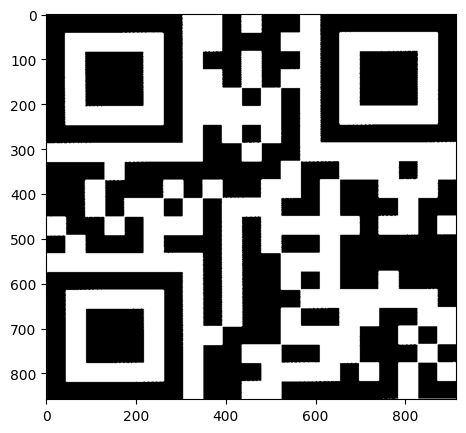

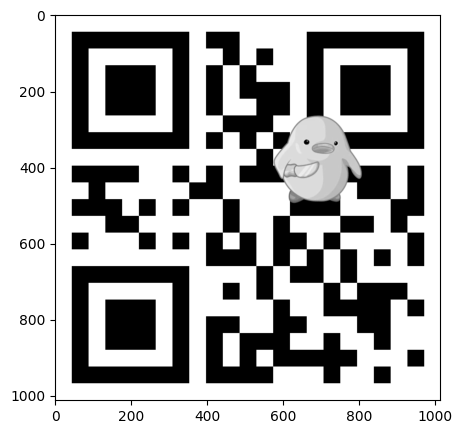

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the path to the shortcut folder
folder_path = '/content/drive/My Drive/CSE483 Sp24 Project Test Cases'

# Step 5: Process each image in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(folder_path, filename)
        # print(f'Processing {image_path}')
        processed_image = process_image(image_path)
        plt.figure(figsize=(10, 5))
        plt.imshow(processed_image, cmap='gray')
        plt.show()

        # # Save the processed image if needed
        # output_path = os.path.join(folder_path, 'processed_' + filename)
        # cv2.imwrite(output_path, processed_image)
        # print(f'Saved processed image to {output_path}')